<a href="https://colab.research.google.com/github/visiont3lab/machine_learning/blob/master/11-ClassificationProject/multilabel_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's build a custom classifier

## Terminology

* Binary Classification:
Un classificatore binario distingue tra due classi. Se l'oggetto da classificare appare più volte per esempio in un immagine verrà classificato una volta sola.
* Multiclass or multinomial Classification: classificatore capace di distinguere tra più di due classi. Alcuni algoritmi come Random Forest e naive Bayes Classifier gestiscono automaticamente questo concetto di classi multiple. Support vector machine e Linear Classifier invece sono strettamente dei classificatori binary. Tuttavia è possibile utilizzare un classificatore binario per risolvere un problema dove vi sono più classi. Infatti se pensiamo a un problema dove bisogna distinguere il numero 1 dal 2 e dal 3 quello che possiamo fare è allenare tre diversi classificatori binari (one vs rest approach) capaci di distinguere tra 1 e tutto il resto (2,3), poi il 2 e tutto il resto (1,3) e poi il 3 e tutto il resto (1,2). Al fine di scegliere a quale classe appartiene un nuovo output tutti e tre i calssificatori daranno un risultato e si sceglierà il migliore. Esiste anche la possibilità (one vs one) di allenare  $N=3$  $3 × (3 – 1) / 2$ tre classicatori binari (1-2), (1-3),  (2-3). Da notare che quest'ultimo approccio (one vs one) nel caso di N_classi = 10 richiederà $N × (N – 1) / 2 = 10x(4.5)=45$ classificatori binari mentre il (one vs rest) richiederà 10 classificatori binari. Support vector machine usa one vs one pertanto ad allenare è abbastanza lento. È consigliato nel caso di Support vector machine di usare one vs one perchè nel caso di dataset molto grandi one vs rest richiederebbe un tempo di allenamento maggire di quello del one vs one anche se il numero di classificatori (nel caso di one vs one) è maggiore.   
* Multilabel Classification: Fino ad adesso abbiamo visto che il classificatore darà come output un unica classe. Tuttavia vi sono situazione dove una classe non necessariamente esclude l'altra. Se alleniamo un classificatore capace di distingue tra Marco, Giada e Francesca che succede se tutti e tre appaiono in un immagine. Vorrei che il mio algoritmo ritornasse come risultato [1,1,1] cioè che mi dicesse che in un immagine c'è sia marco che francesca che giada e non solo uno di essi. 
KNeighborsClassifier sopporta multilabel classification. Da notare che non tutti i classificatori la sopportano. Questo tipo di classificatore è molto interessante. Se vogliamo per esempio creare un classificatore capace di dire se un numero è maggiore di 7 e anche se è dispari dobbiamo usare un multilabel classifier. Questo accade perchè vi possono essere situazione numero 9 per esempio che è sia maggiore di 7 che dispari. Qundi il  nostro algoritmo dovrà dare come output più classi. 
* Multioutput Classification:
Un altro di classificazione è multioutput-multiclass classification. In essa succede che l'output per ogni classe non è un valore tra 0 e 1  ma può essere un numero qualsiasi. Per esempio proviamo a creare un classificatore capace di rimuove il rumore da un immagine. Il numero di classi di output del classificatore saranno tutti i pixel dell'immagine (multi label) e tutti questi avranno un valore (intensità) pertanto multi output. Quindi abbiamo un classificatore capace di dare come output più labels contemporaneamente con un valore specifico (non solo vero falso)

* Note Object Detection: se volessimo dire che un oggetto appare più volte in un immagine. Per esempio se abbiamo un classificatore che distingue tra telefoni, computer e persone. Mi piacerebbe che quando ci siano persone in immagine mi dica non solo che ci sono persone ma anche che ce ne sono N. Per fare è necessario che l'immagine venga divisa in N regione dove appaiono le persone e poi che venga passata al classificatore. Siamo nell'area di object detection.


Un ottimo modo per misurare le performance di classicatore è usare l' F1 score che è la media harmonica (harmonic mean) tra precision e recall.


## Defianiamo che tipo di classificatore ci serve

* Binary classifier: Il nostro classificatore deve distingure solo tra due classi?
* Multiclass classifier: Il nostro classificatore deve scegliere una classe tra più di due classi? Una sola classe sarà data come output.
* Multilabel classifier: Non vogliamo distinguere completamente tra le classi. È possibile che diverse classi siano vere o false allo stesso tempo.  Non distinguo tra classi ma rispondo a domande associate a delle classi.
* Multi output classifier: in questo caso abbiamo n classi e per ognuna di esse abbiamo un output specifico. Non rispondo solo a domande associate a classi dicendo vero o falso ma ci associo anche un numero. 
* Object detection: Vogliamo un classificatore capace sia di dare come output più classi conteporanemente (multilabel) ma anche che sia in grado di capire quando vi sono più instanze della stessa classe nell'immagine.  Da notare che non distingue tra oggetti della stessa classe, ci dice soltanto che più oggetti della stessa classe appaiono.
* Instance Segmenation:
Object detection e in più distingue tra elementi della stessa classe.

## Import Libraries

In [0]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score,recall_score, confusion_matrix,f1_score
from sklearn.metrics import precision_recall_curve,roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

import os
import cv2

from IPython.display import clear_output

In [0]:
def save_model(inp_name,inp_clf):
    #https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn
    with open(inp_name, 'wb') as f:
        pickle.dump(inp_clf, f) 

def load_model(inp_name):
    with open(inp_name, 'rb') as f:
        out_clf = pickle.load(f)
        return out_clf

def roc_analysis_full(Y_test,Y_scores,n_classes):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    # Compute ROC curve and ROC area for each class
    Y_test = label_binarize(Y_test, classes=[*range(n_classes)]) # make categorical
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw=2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.4f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    
    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.4f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.4f})'
                ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

def prediction_recall_full(Y_test,Y_scores,n_classes):
    Y_test = label_binarize(Y_test, classes=[*range(n_classes)]) # make categorical
    # https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
    precision = dict()
    recall = dict()
    threshold = dict() 
    fig = plt.figure()
    for i in range(n_classes):
        precision[i], recall[i], threshold[i] = precision_recall_curve(Y_test[:, i], Y_scores[:, i])
        #print(threshold[i].shape)
        #print(recall[i][:-1].shape)
        ax = fig.add_subplot(5,2,i+1)
        ax.plot(threshold[i], precision[i][:-1], 'b--', label='precision ' + "class_" + str(i))
        ax.plot(threshold[i], recall[i][:-1],'g-', label='recall')
        ax.legend()
        ax.grid()

    #plt.xlabel("Probabilities Threshold")
    #plt.ylabel("Percentage")
    plt.show()

def precision_vs_recall(Y_test,Y_scores,n_classes):
    Y_test = label_binarize(Y_test, classes=[*range(n_classes)]) # make categorical
    # precision recall curve
    precision = dict()
    recall = dict()
    for i in range(0,n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],Y_scores[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

def get_thresholds(Y_test,Y_proba,n_classes, precision_vec):
    Y_test = label_binarize(Y_test, classes=[*range(n_classes)]) # make categorical
    precision = dict()
    recall = dict()
    threshold = dict() 
    thresholds_chosen = np.zeros(n_classes)
    for i in range(n_classes):
        precision[i], recall[i], threshold[i] = precision_recall_curve(Y_test[:, i], Y_proba[:, i])
        precision_chosen = precision_vec[i]
        threshold_chosen = threshold[i][np.argmax(precision[i] >= precision_chosen)]
        thresholds_chosen[i]=threshold_chosen
    return thresholds_chosen


## Load the Dataset 

### Mnist dataset

In [3]:
mnist = fetch_openml('mnist_784', version=1)
n_classes = 10
X = mnist["data"]
Y = mnist["target"]
print(mnist.keys())
Y = Y.astype(np.uint8) # convert string target to int
#Y = label_binarize(Y, classes=[*range(n_classes)]) # make categorical
X = np.array(X, dtype="float32")
Y = np.array(Y, dtype="float32")


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


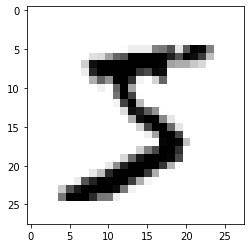

In [4]:
#------------------------------------#
# Initial check
sample_img = X[0]  
sample_img = sample_img.reshape(28, 28)
plt.imshow(sample_img, cmap = mpl.cm.binary,interpolation="nearest")

### Custom Gesture Dataset

In [77]:
# Dataset link: https://drive.google.com/open?id=1l-9KXCF8yR9vbnNq3YQFHkje_Qu7xQnQ
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [0]:
!unzip dataset.zip 

In [0]:
# Load Custom Dataset
n_classes = 5
X = []
Y = []
for i in range(0,n_classes):
    folder_path = "dataset/sign_" + str(i+1)
    for name in os.listdir(folder_path):
        path_read = folder_path + "/" + name
        im = cv2.imread(path_read,0)
        im = cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
        im = im.reshape(256*256)
        X.append(im)
        Y.append(i)

X = np.array(X, dtype="float32")
Y = np.array(Y, dtype="float32")

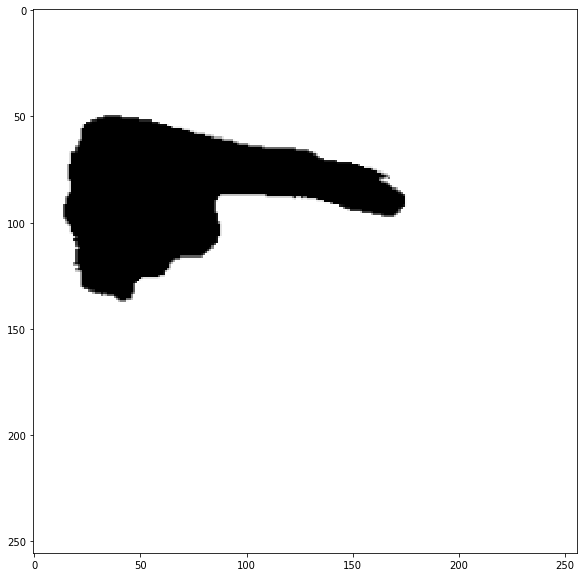

In [94]:
#------------------------------------#
# Initial check
sample_img = X[0]  
sample_img = sample_img.reshape(256, 256)
plt.imshow(sample_img, cmap = mpl.cm.binary,interpolation="nearest")

## Preprocessing

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (49000, 784)
Y_train shape:  (49000,)
X_test shape:  (21000, 784)
Y_test shape:  (21000,)


In [0]:
#------------------------------------------#
# Standard Scaler Standardize features by removing the mean and scaling to unit variance
# MinMax Scaler This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
scaler = StandardScaler()
scaler.fit(X_train)
print("scaler mean: ", scaler.mean_)
X_train = scaler.transform(X_train)


In [0]:
# -----------------------------------------#
# Dimensionality reduction works really well with StandardScaler because il looks at the variace distribution
# Standard scaler required
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
print("pca variance ratio: ",pca.explained_variance_ratio_)

In [0]:
# -----------------------------------------#
# Add White Noise
# 0 is the mean of the normal distribution you are choosing from
# 1 is the standard deviation of the normal distribution
# 100 is the number of elements you get in array noise
noise = np.random.normal(0,1,X_train.shape)
X_train = X_train + noise

## Classifier choice

In [0]:
#----------------------------------------------------#
#clf = LogisticRegression()
#name = "logistic_regression.pkl"
#----------------------------------------------------#
#clf = tree.DecisionTreeClassifier(max_depth = 2) #  tree.DecisionTreeClassifier(criterion='gini')
#name = "decision_tree.pkl"
#----------------------------------------------------#
#clf = KNeighborsClassifier(n_neighbors = 7, p = 2)
#name = "knn.pkl"
#----------------------------------------------------#
#clf = SVC(kernel='linear',probability=True) #'rbf', random_state=667, gamma=.10, C=1.0)
#name = "svm.pkl"
clf = RandomForestClassifier() 
#clf = OneVsRestClassifier(clf) # one vs rest approach one vs one
name = "random_forest.pkl"
#----------------------------------------------------#
#clf = AdaBoostClassifier(n_estimators=200, random_state= 667, learning_rate=0.01)
#name = "ada_boost.pkl"
#clf = GradientBoostingClassifier(n_estimators=200, random_state=667, learning_rate=0.01)
#name = "gradient_boost.pkl"

In [11]:
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
score_train = cross_val_score(clf, X_train, Y_train, cv=3, scoring="f1_weighted")
score_test= cross_val_score(clf, X_test, Y_test, cv=3, scoring="f1_weighted")
print("f1_weighted score train set split in 3 set: ", score_train)
print("f1_weighted score test set split in 3 set: ", score_test)

f1_weighted score train set split in 3 set:  [0.96495519 0.96433854 0.96391054]
f1_weighted score test set split in 3 set:  [0.95252192 0.95867351 0.95304815]


In [0]:
# Saving Model
save_model(name,clf)

In [14]:
Y_proba = clf.predict_proba(X_test)
Y_scores = clf.predict(X_test)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
precision_vec = precision_score(Y_test, Y_scores, average=None) # average="weighted"
recall_vec = recall_score(Y_test, Y_scores, average=None)   #  average="weighted"
precision = precision_score(Y_test, Y_scores, average="weighted")
recall = recall_score(Y_test, Y_scores, average="weighted")
cm = confusion_matrix(Y_test, Y_scores)
#thresholds_chosen = get_thresholds(Y_test,Y_proba,n_classes,precision_vec)
print("Precision Vector: ")
print(np.round(precision_vec,4))
print("Recall Vector: ")
print(np.round(recall_vec,4))
print("Precision Average: ")
print(np.round(precision,6))
print("Recall Average: ")
print(np.round(recall,6))
print("Confusion Matrix: ")
print(cm)

Precision Vector: 
[0.9806 0.9807 0.9525 0.9552 0.9672 0.9704 0.9744 0.9686 0.9578 0.9528]
Recall Vector: 
[0.983  0.9869 0.9681 0.9494 0.9747 0.9593 0.9832 0.9617 0.9468 0.9459]
Precision Average: 
0.966125
Recall Average: 
0.966143
Confusion Matrix: 
[[2023    0    7    0    2    2    8    2   14    0]
 [   0 2333   11   10    2    2    1    4    1    0]
 [   4    6 2065    9    6    2   11   15   13    2]
 [   4    1   28 2066    1   20    2   21   18   15]
 [   1    3    4    0 1887    0    4    5    2   30]
 [   8    3    3   27    1 1837   13    3   13    7]
 [   5    2    2    0    9   12 2053    0    5    0]
 [   2   10   30    1    9    1    0 2162    4   29]
 [   3   13   13   24    8   11   13    6 1886   15]
 [  13    8    5   26   26    6    2   14   13 1977]]


## Performance Analysis



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


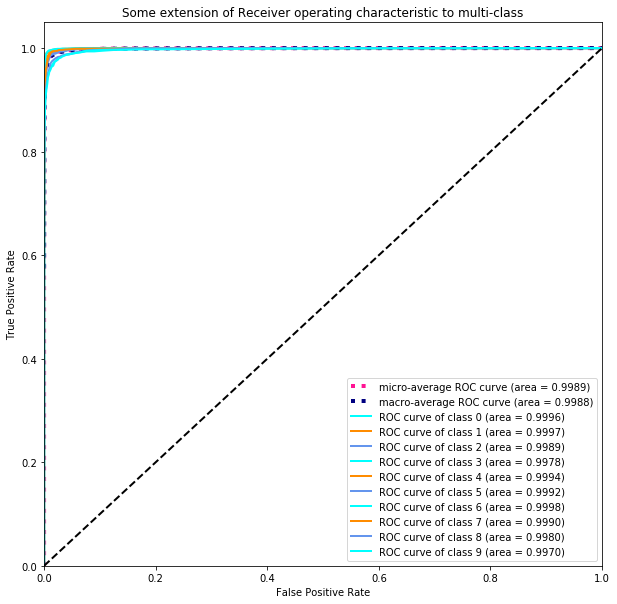

In [15]:
plt.rcParams['figure.figsize'] = [10, 10]
roc_analysis_full(Y_test,Y_proba,n_classes)

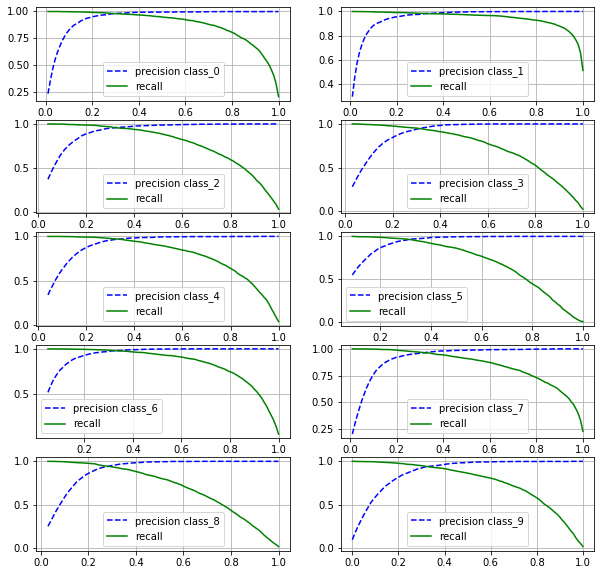

In [16]:
prediction_recall_full(Y_test,Y_proba,n_classes)

In [17]:
thresholds_chosen = get_thresholds(Y_test,Y_proba,n_classes, precision_vec)
print("Thresholds Chosen: ", thresholds_chosen)
# This are the selected threshold if each classifier is seen as binary (one vs rest)

Thresholds Chosen:  [0.3  0.32 0.31 0.33 0.33 0.34 0.31 0.34 0.32 0.38]


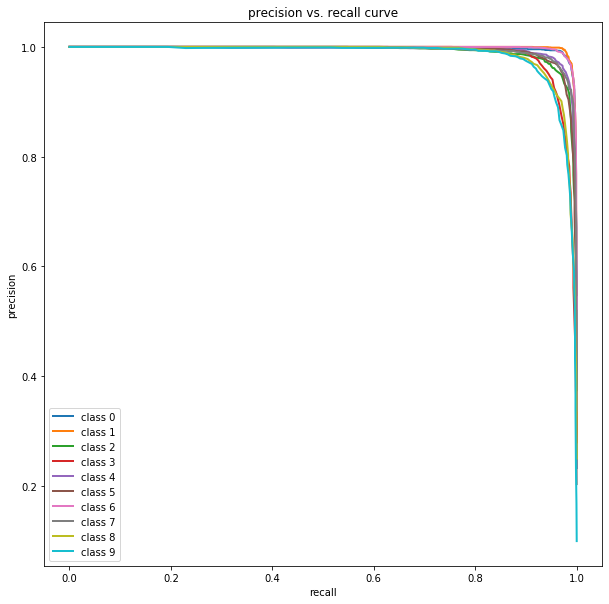

In [18]:
precision_vs_recall(Y_test,Y_proba,n_classes)

### Test

Prediction probability: [[0.03 0.01 0.   0.14 0.   0.77 0.   0.   0.04 0.01]]
Prediction score: [5.]


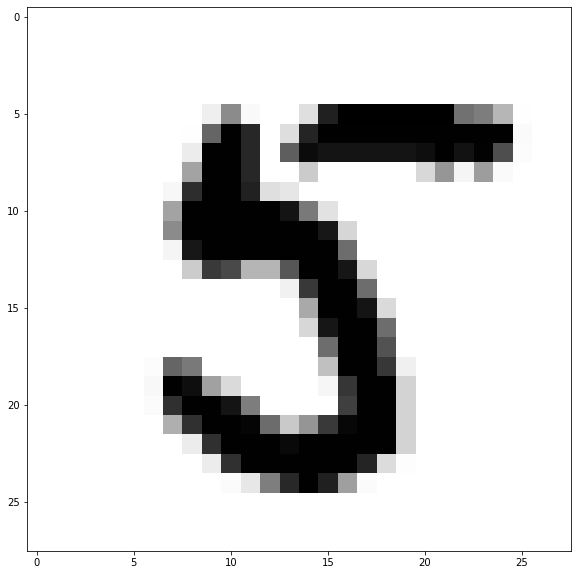

KeyboardInterrupt: ignored

In [20]:
clf = load_model("random_forest.pkl")
size =  (28,28) #(256,256) 
for i in range(0,X_test.shape[0]):
  test_img = X_test[i]  
  Y_proba_test = clf.predict_proba([test_img])
  Y_score_test = clf.predict([test_img])
  test_img = test_img.reshape(size)
  clear_output()
  print("Prediction probability:", Y_proba_test)
  print("Prediction score:", Y_score_test)
  plt.imshow(test_img, cmap = mpl.cm.binary,interpolation="nearest")
  plt.pause(4)
 